In [35]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from constants import *

In [36]:
def load_dataset(fname):
    toret = pd.read_csv(os.path.join(DATA_FOLDER, f"{fname}.csv"))
    return toret.set_index('Date')

In [37]:
smart_beta_prices = load_dataset("10y_prices_smart_beta")
overall_esg_prices = load_dataset("10y_prices_overall_esg")
env_esg_prices = load_dataset("10y_prices_env_esg")
soc_esg_prices = load_dataset("10y_prices_soc_esg")
idx_tracker_prices = load_dataset("10y_prices_index_trackers")
smart_beta_esg_prices = load_dataset("10y_prices_smart_beta_esg")
full_price_data = smart_beta_prices.merge(overall_esg_prices, left_index=True, right_index=True, how="outer") \
                            .merge(env_esg_prices, left_index=True, right_index=True, how="outer") \
                            .merge(soc_esg_prices, left_index=True, right_index=True, how="outer") \
                            .merge(idx_tracker_prices, left_index=True, right_index=True, how="outer") \
                            .merge(smart_beta_esg_prices, left_index=True, right_index=True, how="outer")

In [38]:
smart_beta_returns = smart_beta_prices.pct_change().dropna()
overall_esg_returns = overall_esg_prices.pct_change().dropna()
env_esg_returns = env_esg_prices.pct_change().dropna()
soc_esg_returns = soc_esg_prices.pct_change().dropna()
idx_tracker_returns = idx_tracker_prices.pct_change().dropna()
smart_beta_esg_returns = smart_beta_esg_prices.pct_change().dropna()
all_data = smart_beta_returns.merge(overall_esg_returns, left_index=True, right_index=True, how="outer") \
                            .merge(env_esg_returns, left_index=True, right_index=True, how="outer") \
                            .merge(soc_esg_returns, left_index=True, right_index=True, how="outer") \
                            .merge(idx_tracker_returns, left_index=True, right_index=True, how="outer") \
                            .merge(smart_beta_esg_returns, left_index=True, right_index=True, how="outer")

In [39]:
def get_return_and_volatility(dataset, colname, period=12, ignore_small=True):
    if not ignore_small and dataset[colname].isna().sum() > 1:
        return np.nan, np.nan
    rets = dataset[colname].dropna().values
    return (1 + rets.mean()) ** period - 1, rets.std() * np.sqrt(period)

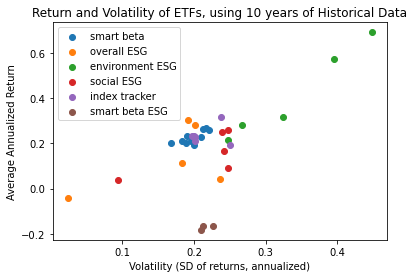

In [40]:
data = {}
for group, name in [(SMART_BETA_TICKERS, "smart beta"),
              (OVERALL_ESG_TICKERS, "overall ESG"),
              (ENVIRONMENT_ESG_TICKERS, "environment ESG"),
              (SOCIAL_ESG_TICKERS, "social ESG"),
                (INDEX_TRACKER_TICKERS, "index tracker"),
                (SMART_BETA_ESG_TICKERS, "smart beta ESG")]:
    xs = []
    ys = []
    for ticker in group:
        y, x = get_return_and_volatility(all_data, ticker, period=365)
        # print(f"x: {x}, y: {y} for {ticker}")
        xs.append(x)
        ys.append(y)
        data[ticker] = [x, y, name]
    plt.scatter(xs, ys, label=name)
plt.title("Return and Volatility of ETFs, using 10 years of Historical Data")
plt.xlabel("Volatility (SD of returns, annualized)")
plt.ylabel("Average Annualized Return")
plt.legend();
plt.savefig(os.path.join(IMG_FILE, "ret_vol_10y"))

In [41]:
r_f = .0281
ten_yr_data = pd.DataFrame().from_dict(data).T
ten_yr_data.columns = ["Volatility", "Return", "Group"]
ten_yr_data['Sharpe Ratio'] = (ten_yr_data["Return"] - r_f) / ten_yr_data["Volatility"]
ten_yr_data[['Sharpe Ratio', 'Group']].groupby('Group').agg(["mean", "median"])

Sharpe Ratio          
                        mean    median
Group                                 
environment ESG     1.086555  0.946326
index tracker       0.971294  1.011651
overall ESG         0.071382  0.462422
smart beta          0.998935  1.018773
smart beta ESG     -0.927605 -0.919167
social ESG          0.554411  0.565790

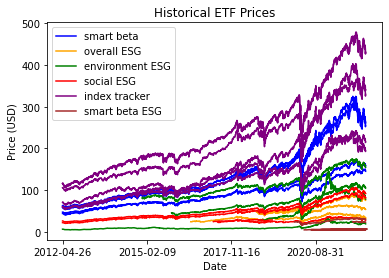

In [42]:
num_to_plot = 4
fig = plt.figure()
ax = fig.subplots()
for group, name, color in [(SMART_BETA_TICKERS[:num_to_plot], "smart beta", "blue"),
              (OVERALL_ESG_TICKERS[:num_to_plot], "overall ESG", "orange"),
              (ENVIRONMENT_ESG_TICKERS[:num_to_plot], "environment ESG", "green"),
              (SOCIAL_ESG_TICKERS[:num_to_plot], "social ESG", "red"),
                (INDEX_TRACKER_TICKERS, "index tracker", "purple"),
                (SMART_BETA_ESG_TICKERS[:num_to_plot], "smart beta ESG", "brown")]:
    first = True
    for ticker in group:
        if first:
            ax.plot(full_price_data[ticker].dropna(), color=color, label=name)
        else:
            ax.plot(full_price_data[ticker].dropna(), color=color)
        first = False
ax.set_title("Historical ETF Prices")
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Date")
ax.set_xticks(ax.get_xticks()[::700])
plt.legend();
plt.savefig(os.path.join(IMG_FILE, "prices_10y"))

In [43]:
yf_aggregate_stats = pd.read_csv(os.path.join(DATA_FOLDER, "yf_agg_data.csv"))
three_yr_cols = ['3y return', '3y Beta', '3y Sharpe Ratio', '3y SD']
five_yr_cols = ['5y return', '5y Beta', '5y Sharpe Ratio', '5y SD']
yf_aggregate_stats

,Name,Group,3y return,3y Beta,3y Sharpe Ratio,Unnamed: 5,3y SD,5y return,5y Beta,5y Sharpe Ratio,5y SD
0,CRBN,Environment ESG,1.23,1.00,1.45,NaN,17.26,1.03,1.00,1.80,15.16
1,ERTH,Environment ESG,1.75,1.25,0.74,NaN,25.07,1.40,1.25,1.18,21.78
2,SPYX,Environment ESG,1.59,0.99,0.56,NaN,17.61,1.35,99.81,0.98,15.70
3,ICLN,Environment ESG,2.75,1.18,0.40,NaN,33.15,2.01,1.16,0.99,28.06
4,CNRG,Environment ESG,3.39,1.32,0.17,0.6640,36.08,NaN,NaN,NaN,NaN
5,IWM,Index Tracker,1.16,1.17,3.35,1.1800,23.70,0.96,1.18,3.32,21.18
6,SPY,Index Tracker,1.58,1.00,0.80,NaN,17.71,1.34,1.00,1.23,15.73
7,QQQ,Index Tracker,2.17,1.03,-0.28,NaN,19.80,1.88,1.06,0.05,18.06
8,IVV,Index Tracker,1.58,1.00,0.82,NaN,17.76,1.34,1.00,1.25,15.78
9,DIA,Index Tracker,1.12,0.99,1.07,NaN,18.19,1.15,0.98,1.43,10.81


In [44]:
three_yr_stats = yf_aggregate_stats[three_yr_cols + ['Group']].dropna().groupby('Group').agg({
    "3y Sharpe Ratio" : "mean",
})
three_yr_stats.columns = ["Average 3y Sharpe Ratio"]
three_yr_stats

,Average 3y Sharpe Ratio
Group,
Environment ESG,0.6640
Index Tracker,1.1800
Overall ESG,1.3425
Smart Beta,1.1620
Social ESG,0.8150


In [45]:
five_yr_stats = yf_aggregate_stats[five_yr_cols + ['Group']].dropna().groupby('Group').median()
five_yr_stats.columns = ["Median " + a for a in five_yr_stats.columns]
five_yr_stats

,Median 5y return,Median 5y Beta,Median 5y Sharpe Ratio,Median 5y SD
Group,,,,
Environment ESG,1.375,1.205,1.085,18.74
Index Tracker,1.325,1.015,1.340,16.07
Overall ESG,0.990,1.010,1.105,16.41
Smart Beta,1.220,0.995,1.345,15.43
Social ESG,1.360,1.000,1.340,11.38


In [46]:
ALL_THEME_TICKERS = HEALTHY_TICKERS + HEALTHY_SB_TICKETS + CARBON_THEME_TICKERS + CARBON_THEME_SB_TICKERS + \
                             WATER_CLEAN_ENERGY_TICKERS + WATER_CLEAN_ENERGY_SB_TICKERS

theme_etf_3y = load_dataset("3y_prices_theme_etfs")
theme_etf_returns_3y = theme_etf_3y.pct_change()
data = {}
for ticker in ALL_THEME_TICKERS:
    ret, vol = get_return_and_volatility(theme_etf_returns_3y, ticker, period=12, ignore_small=False)
    data[ticker] = [ret, vol]

result = pd.DataFrame().from_dict(data).T
result.columns = ["Return", "Volatility"]
(result * 100).to_csv(os.path.join(DATA_FOLDER, "3y_theme_ret_vol.csv"))

In [47]:
theme_etf_5y = load_dataset("5y_prices_theme_etfs")
theme_etf_returns_5y = theme_etf_5y.pct_change()
data = {}
for ticker in ALL_THEME_TICKERS:
    ret, vol = get_return_and_volatility(theme_etf_returns_5y, ticker, period=12, ignore_small=False)
    data[ticker] = [ret, vol]

result = pd.DataFrame().from_dict(data).T
result.columns = ["Return", "Volatility"]
(result * 100).to_csv(os.path.join(DATA_FOLDER, "5y_theme_ret_vol.csv"))